# Data Challenge - West Nile Virus
---

### Insights from description / research:

* West Nile virus (WNV) is carried by female mosquitoes in the *Culex* genus.
* *Culex* feed on birds, which are the final hosts for the virus, humans/horses are incidental hosts. 
* *Culex* females can enter a state of hybernation during the winter and emerge to feed as it gets warmer.
* Like other mosquitoes, *Culex* lays eggs in water and has aquatic larvae / pupae.
* Mosquitoes aquire the virus by feeding on birds infected by the WNV (usually American crows, Blue Jays and American Robins), but cannot pass it along to other hosts (usually other birds but potentially humans) until the virus has multiplied and reached the salivary glands (i.e. extrinsic incubation period). 
* Warm weather accelerates mosquito development from egg to adult and also accelerates the extrinsic incubation for (WNV) in mosquitoes.
* Most bites occur outdoors (*Culex* targets birds) from dusk to dawn
* WNV is likely underreported, as it is asymptomatic in 75% of the cases; the remaining 25% of the cases manifest WNV fever and 1/140 of those cases develop into potentially fatal WNV encephalitis. 
* Risk to develop WNV encephalitis roughly doubles for every 10 years of age, taking demographics into account is key to prioritize prevention measures (get rid of still water sources around residential area to prevent reproduction, use larvicides to kill larvae, pupae and spray pesticides to kill adults) .

## Contents
----
1. EDA 
    1. Mosquito trapping <a href='#1.A'>[1.A]</a>
    2. Weather <a href='#1.B'>[1.B]</a>
    
2. Feature selection <a href='#2'>[2]</a>

3. Feature engineering I: Adding past weather <a href='#3'>[3]</a>
 
4. MVP: regression tree <a href='#4'>[4]</a>

5. Feature engineering II: interpolate climate data <a href='#5'>[5]</a>

6. Final model <a href='#6'>[6]</a>
7. Conclusions <a href='#7'>[7]</a>

## Explore Datasets - Training Data <a id='1.A'></a>
---

In [1]:
# import libraries
import os

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict, Counter

from shapely.geometry import Point
import plotnine as p9
import folium
from jupyterthemes import jtplot

# plot styles
jtplot.style('grade3')

# read data
traps = pd.read_csv('train.csv')

# convert Date to datetime
traps['Date'] = [datetime(*[int(ele) for ele in date.split('-')]) for date in traps['Date']]


print(f"number of collections events: {len(traps)}")
print(f"number of traps: {len(pd.unique(traps.Trap))}")
print(f"first collection: {min(traps.Date)}")
print(f"last collection: {max(traps.Date)}")

number of collections events: 10506
number of traps: 136
first collection: 2007-05-29 00:00:00
last collection: 2013-09-26 00:00:00


### Explore training data - plot trap and mosquito species density

/home/bento/anaconda3/envs/birding/lib/python3.7/site-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
  PlotnineWarning)


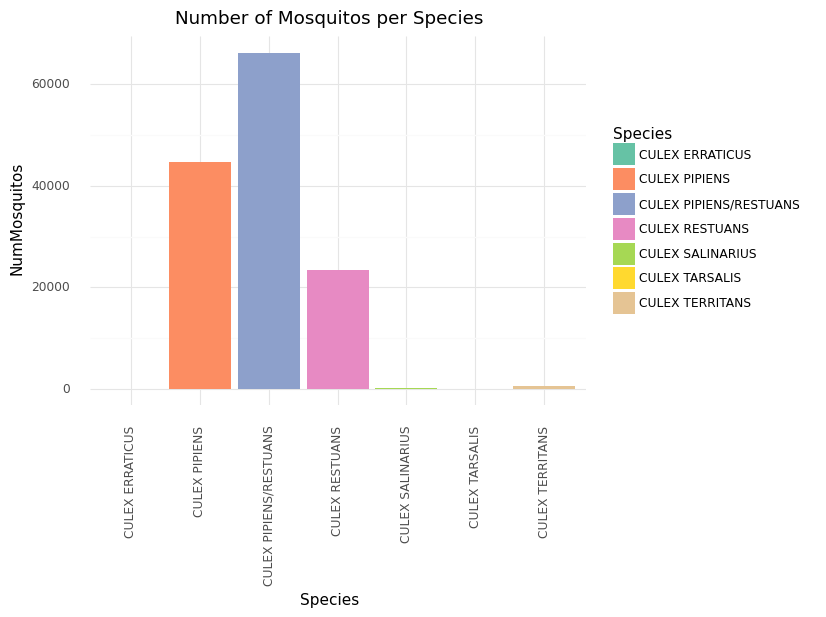

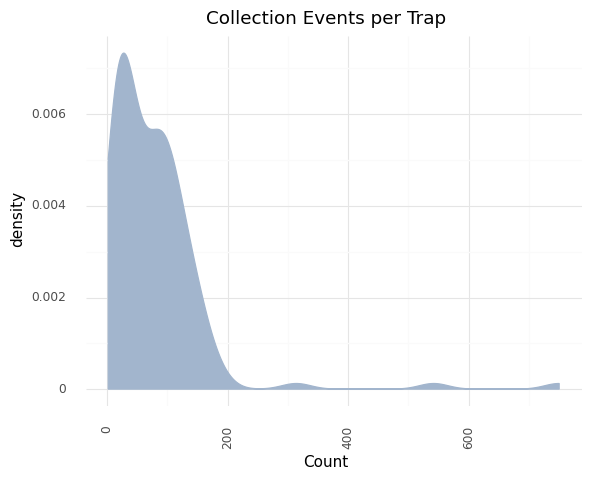

In [2]:
# inspect traps data 
def plot_col(data, x_label, y_label=None, fill_label=None, to_add=[], title=''):
    # check for custom fill
    if not fill_label:
        fill_label = x_label
    
    # column plot 2D
    if y_label:
        hist_plot = (p9.ggplot(data=data,
                               mapping=p9.aes(x=x_label, y=y_label,
                                       fill=fill_label)) +
                               p9.geom_col())
    
    # density plot 1D
    else:
        hist_plot = (p9.ggplot(data=data,
                               mapping=p9.aes(x=x_label)) +
                               p9.geom_density(fill='#A2B5CD', color='#A2B5CD'))
    
    # add theme and title
    hist_plot = (hist_plot + 
                 p9.theme_minimal() + 
                 p9.ggtitle(title) +    
                 p9.scale_fill_brewer(type='qual', palette=7) +
                 p9.theme(axis_text_x=p9.element_text(rotation=90))) 

    
    # add additional features
    for ele in to_add:
        hist_plot = hist_plot + to_add
    hist_plot.draw()
    
# histogram number of mosquitoes by species
cnt_by_species = traps.groupby(['Species']).sum()
cnt_by_species['Species'] = list(cnt_by_species.index)
plot_col(cnt_by_species, 'Species', 'NumMosquitos', title='Number of Mosquitos per Species')

# histogram number of deployments by trap
deployments = Counter(traps.Trap)
deployments = pd.DataFrame({'TrapID': [key for key in deployments],
                            'Count': [val for val in deployments.values()]})
plot_col(deployments, 'Count', title='Collection Events per Trap')


### Plot infections by Species and Date

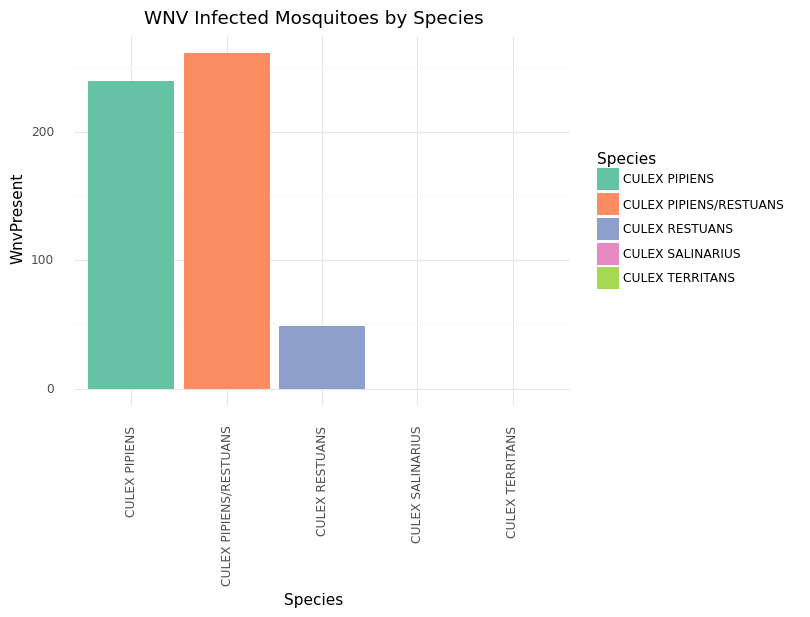

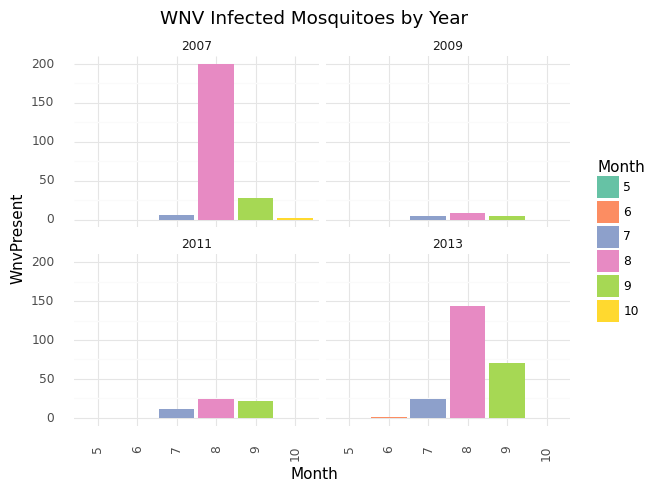

In [3]:
# remove species with very low counts
traps = traps.loc[traps.Species.isin(['CULEX PIPIENS',
                                      'CULEX RESTUANS',
                                      'CULEX PIPIENS/RESTUANS',
                                      'CULEX TERRITANS',
                                      'CULEX SALINARIUS'])]

# histogram number of cases by species
wnv_by_species = traps.groupby(['Species']).sum()
wnv_by_species['Species'] = list(wnv_by_species.index)
plot_col(wnv_by_species, 'Species', 'WnvPresent', title='WNV Infected Mosquitoes by Species')


# histogram number of cases per month, blocked by year
traps['Year'] = [ele.year for ele in traps.Date]
traps['Month'] = [ele.month for ele in traps.Date]
wnv_by_time = traps.groupby(['Year', 'Month']).sum()
wnv_by_time['Month'] = pd.Categorical([str(ele[1]) for ele in wnv_by_time.index],
                                     categories=[str(ele) for ele in range(5, 11)],
                                     ordered=True)
wnv_by_time['Y'] = [ele[0] for ele in wnv_by_time.index]
plot_col(wnv_by_time, 'Month', 'WnvPresent', 'Month', 
         [p9.facet_wrap('Y')], title='WNV Infected Mosquitoes by Year')

### Map traps, Weather stations and WNV reports

In [4]:
# create map for traps samples 
lat, lon = [41.8, -87.65]
matches_map = folium.Map(location=[lat, lon], width=900, height=540,
                         tiles='Stamen Terrain', zoom_start=10)

# add wnv cases to the map
by_trap = traps.groupby('Trap').mean()
for trap, row in by_trap.iterrows():
    deploys = float(deployments.loc[deployments.TrapID == trap]['Count'].values[0])
    folium.Circle(tuple([row.Latitude, row.Longitude]), color='black', radius=deploys * 2,
                         weight=1.5, fill_color='red', fill_opacity=row.WnvPresent * 6).add_to(matches_map)

# add weather stations
folium.Marker(
    location=[41.995, -87.933],
    tooltip="NOAA Station 1: Chicago O'Hare",
    icon=folium.Icon(icon='cloud')
).add_to(matches_map)
folium.Marker(
    location=[41.786, -87.752],
    tooltip="NOAA Station 2: Chicago Midway",
    icon=folium.Icon(icon='cloud')
).add_to(matches_map)


matches_map

* Each circle is centered at a trap deployment location.
* Larger circles indicate traps that were deployed a larger number of times.
* Darker cirlces indicate traps that reported a larger number of mosquitoes carrying the WNV.

### Look for correlations between species in traps

CULEX PIPIENS appears alone 252.0 times

CULEX PIPIENS/RESTUANS appears alone 991.0 times

CULEX RESTUANS appears alone 443.0 times

CULEX SALINARIUS appears alone 8.0 times

CULEX TERRITANS appears alone 17.0 times



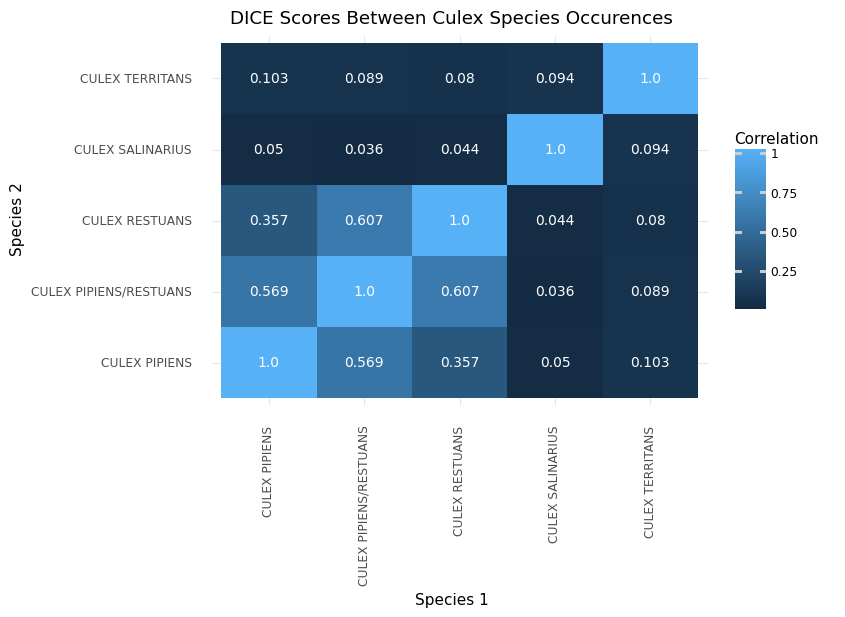

In [5]:
from scipy.stats import spearmanr

# get cooccuring species per trap event
cooccurring = traps.groupby(['Date', 'Trap']).agg({'Species': lambda x: '_'.join(x),
                                                     'NumMosquitos': lambda x: '_'.join(str(x))})

# create cooccurence matrix
species = {species: idx for idx, species in enumerate(sorted(set(traps.Species)))}
cooccurring_matrix = np.zeros([len(cooccurring), len(species)])

# populate cooccurence matrix and convert to dataframe
idx = 0
for _, row in cooccurring.iterrows():
    spcs = row.Species.split('_')
    for spc in spcs:
        cooccurring_matrix[idx, species[spc]] = 1
    idx += 1
cooccurring_matrix = pd.DataFrame({list(species.keys())[idx]: cooccurring_matrix[:, idx] for idx in range(len(species))})

# find correlations between species
correlation_matrix = pd.DataFrame()
for spc1 in species:
    spc1_vec = cooccurring_matrix[spc1].values
    
    # get dice coefficient for spcs 1 and 2
    for spc2 in species:
        spc2_vec = cooccurring_matrix[spc2].values
        dice = round(sum(spc1_vec * spc2_vec) * 2 / (sum(spc1_vec) + sum(spc2_vec)), 3) 
        correlation_matrix = correlation_matrix.append({'Species 1': spc1, 
                                                        'Species 2': spc2, 
                                                        'Correlation': dice}, ignore_index=True)

# plot correlations
corr_plot = (p9.ggplot(data=correlation_matrix,
                     mapping=p9.aes(x='Species 1', y='Species 2', fill='Correlation'))
             + p9.scale_fill_gradient()
             + p9.geom_tile()
             + p9.geom_text(p9.aes(label='Correlation'), color='white', size=10)
             + p9.theme_minimal()
             + p9.theme(axis_text_x=p9.element_text(angle=90))
             + p9.ggtitle('DICE Scores Between Culex Species Occurences'))
corr_plot.draw()

# find out how often species appear alone
species_alone = defaultdict(int)
for _, row in cooccurring_matrix.iterrows():
    if sum(row.values) == 1:
        for spc, val in row.iteritems():
            species_alone[spc] += val
for species in species_alone:
    print(f"{species} appears alone {species_alone[species]} times\n")

### Observations:

Mosquito data

1. Only 2 of the 6 species carry WNC (Culex Pipiens and Culex Restuans).
2. From the amount of Pipiens/Restuans entries, taxonomists have a hard time destinguishing between the two (apparently it is impossible to do it for preserved specimens).
3. WNV infected mosquitoes peak at August and September (warm).
4. Mosquito species outside the Pipiens/Restuans complex show low correlation looking at DICE scores.

Trap data

1. A few trap stations have hundreds of repetitions while most were only sampled a few times.
2. Correcting for trapping effort will be crucial when deciding on key areas. 
3. Traps close to the Chicago O'Hare airport have an especially high concentration of mosquitos. 

## Explore Datasets - Weather Covariate Data <a id='1.B'></a>
---

In [6]:
# read weather data
weather = pd.read_csv('weather.csv')

# transform Date column to datetime
weather['Date'] = [datetime(*[int(ele) for ele in date.split('-')]) for date in weather['Date']]

print(f"Number of weather recordings: {len(weather)}")
print(f"% collections days with weather recordings: {sum(traps.Date.isin(weather.Date)) * 100 / len(traps)}")

Number of weather recordings: 2944
% collections days with weather recordings: 100.0


### Fill in missing data 

* Strategy -> get the average between the closest non-missing values

In [7]:
# display columns
print(weather.columns)

# display missing value counts
has_missing = weather.apply(lambda x: sum(x == 'M'))
has_missing = has_missing[has_missing > 0]
print(f"\nMissing value count by column: \n\n{has_missing}")

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

Missing value count by column: 

Tavg             11
Depart         1472
WetBulb           4
Heat             11
Cool             11
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
AvgSpeed          3
dtype: int64


In [8]:
# fill in columns with a few missing values
to_fill = has_missing[has_missing < 1000]

# iterate through columns
for col in to_fill.index:
    vec = [str(ele) for ele in list(weather[col])]
    n_items = len(vec)
    
    # find closest neighbors
    for idx, ele in enumerate(vec):
        try:
            float(ele)
        except:
            
            # set trace ammounts to 0 (may appear as "T" or "__T")
            if 'T' in ele:
                vec[idx] = '0'
            else:
                idx_for = idx
                idx_back = idx
                while vec[idx_for][0].isnumeric() == False and idx_for < n_items - 1:
                    idx_for += 1
                while vec[idx_back][0].isnumeric() == False and idx_back > 0:
                    idx_back -= 1
                if vec[idx_back][0].isnumeric() == False:
                    vec[idx] = vec[idx_for]
                elif vec[idx_for][0].isnumeric() == False:
                    vec[idx] = vec[idx_back]
                else:
                    vec[idx] = str(np.mean([float(vec[idx_for]), float(vec[idx_back])]))
    
    # substitute back vector
    weather[col] = [float(ele) for ele in vec]
                

### Plot temperature / rainfall by date

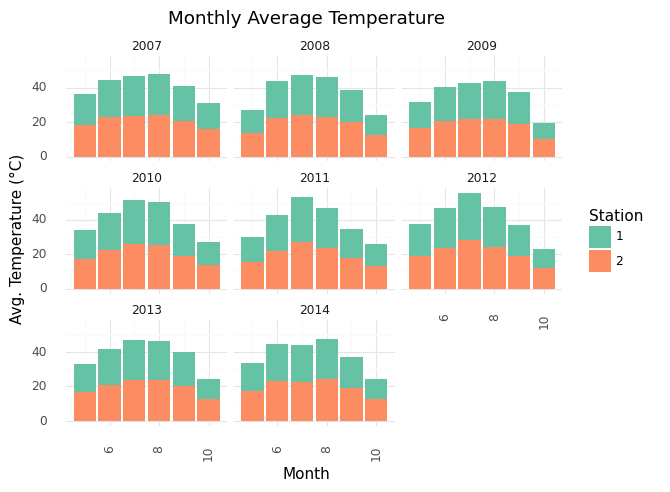

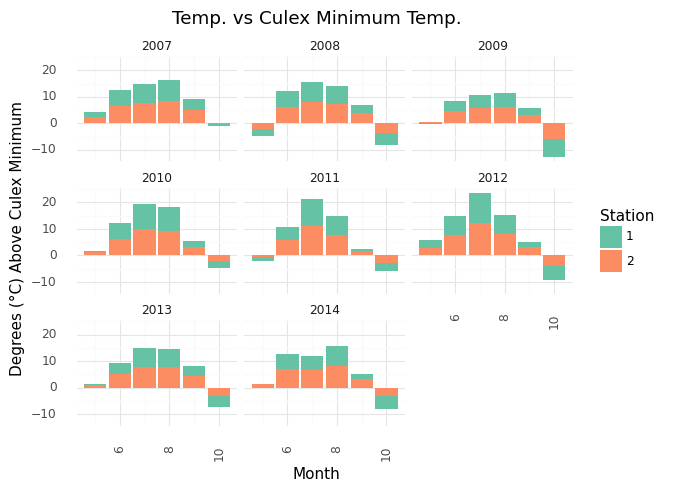

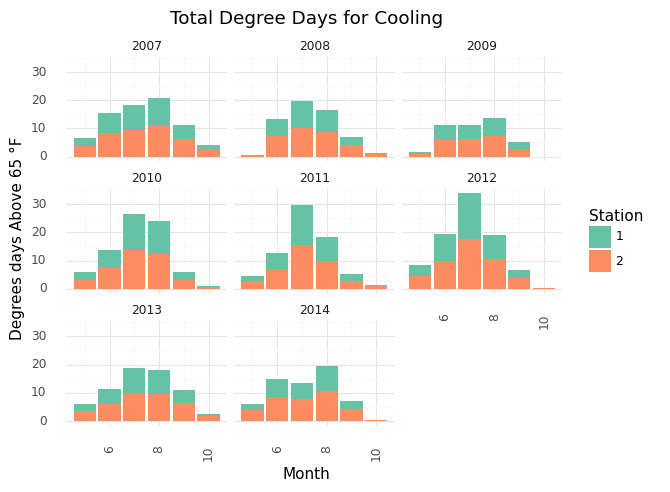

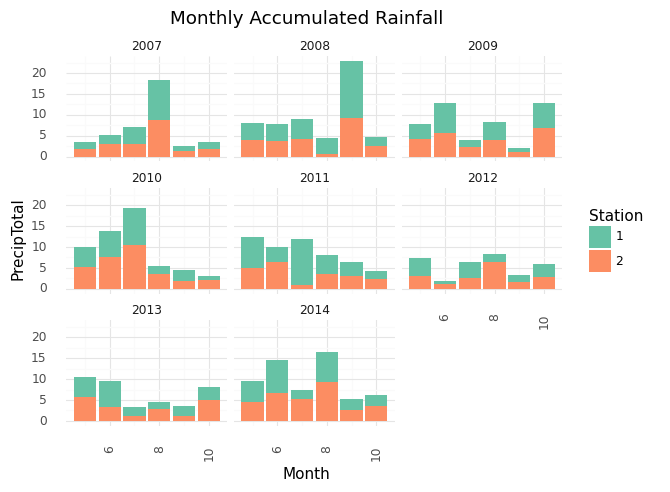

In [9]:
# get month / year
weather['Year'] = [ele.year for ele in weather.Date]
weather['Month'] = [ele.month for ele in weather.Date]

# histogram average temperature by month
temp_by_time = weather.groupby(['Station', 'Year', 'Month']).mean()
temp_by_time['Tavg'] = [(ele - 32) * (5/9) for ele in temp_by_time['Tavg']]
temp_by_time['Month'] = [ele[2] for ele in temp_by_time.index]
temp_by_time['Y'] = [ele[1] for ele in temp_by_time.index]
temp_by_time['Station'] = [str(ele[0]) for ele in temp_by_time.index]
plot_col(temp_by_time, 'Month', 'Tavg', 'Station', [p9.facet_wrap('Y'), p9.ylab('Avg. Temperature (°C)')], 
         title='Monthly Average Temperature')

# histogram temperature above Culex minimum development temperature
temp_by_time['Tavg'] = [ele - 16 for ele in temp_by_time['Tavg']] 
plot_col(temp_by_time, 'Month', 'Tavg', 'Station', [p9.facet_wrap('Y'), p9.ylab('Degrees (°C) Above Culex Minimum')],
         title='Temp. vs Culex Minimum Temp.')


# histogram degree days of cooling
plot_col(temp_by_time, 'Month', 'Cool', 'Station', [p9.facet_wrap('Y'), p9.ylab('Degrees days Above 65 °F')],
        title='Total Degree Days for Cooling')

# histogram total rainfall by month
temp_by_time = weather.groupby(['Station', 'Year', 'Month']).sum()
temp_by_time['Month'] = [ele[2] for ele in temp_by_time.index]
temp_by_time['Y'] = [ele[1] for ele in temp_by_time.index]
temp_by_time['Station'] = [str(ele[0]) for ele in temp_by_time.index]
plot_col(temp_by_time, 'Month', 'PrecipTotal', 'Station', [p9.facet_wrap('Y')], title='Monthly Accumulated Rainfall')

### Observations

* Temperature graph hints that Culex should peak in August / Sep .
* There is substial variation on rainfall by month across years, need to check a minimum rainfall for Culex reproduction.
* Temperature readings are fairly consistent between the two weather stations but rainfall is often very different.

## Feature selection <a id='2'></a>
---

### Weather

In [10]:
# print columns
print(weather.columns)

# subset of interest for training
subset = ['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Cool', 'WetBulb', 
          'PrecipTotal', 'StnPressure', 'Sunrise', 'Sunset']

# get training subset 
weather_train = weather.drop([col for col in weather.columns if col not in subset], axis=1)

# fill in sunrise  / sunset for station 2 and transform to float
for col in ['Sunrise', 'Sunset']:
    weather_train.loc[weather_train.Station == 2, col] = list(weather_train.loc[weather_train.Station == 1, col])
    weather_train[col] = weather_train[col].astype(np.float32)
    
# approximate humidity from WetBulb
weather_train['Humidity'] = np.array(weather_train['WetBulb']) / np.array(weather_train['Tavg'])
weather_train = weather_train.drop(['WetBulb'], axis=1)


Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Year', 'Month'],
      dtype='object')


* $\frac{\text{WetBulb}}{T_{\text{avg}}} \propto \text{Humidity}$
* Cool = sum of degree days above 65°F 


### Add Past Weather

### Traps

In [11]:
# print columns
print(traps.columns)

# subset of interest for training
subset = ['Date', 'Latitude', 'NumMosquitos', 'Species', 'Longitude', 'WnvPresent']

# get training subset 
traps_train = traps.drop([col for col in traps.columns if col not in subset], axis=1)


Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month'],
      dtype='object')


### Find nearest station for each trap and aggregate date by Station / day

In [12]:
# weather station LAT LON for stations 1 and 2
stations = [Point([-87.933, 41.995]), Point([-87.752, 41.786])]

# find closest station to trap
trap_stations = []
for _, trap in traps_train.iterrows():
    loc = Point([trap.Longitude, trap.Latitude])
    trap_stations.append(np.argmin([loc.distance(station) for station in stations]) + 1)

traps_train['Station'] = trap_stations


# drop latitude and longitude
traps_train = traps_train.drop(['Latitude', 'Longitude'], axis=1)

# keep a count on number of traps by station / day combination
traps_train['N_traps'] = [1 for _ in range(len(traps_train))]

# aggregate by station and day
traps_train = traps_train.groupby(['Date', 'Station']).sum()

## Feature Engineering I:  past Weather conditions <a id='3'></a>
---

In [13]:
# aggregate weather data by data 
weather_train = weather_train.groupby(['Date', 'Station']).sum()

# columns of interest for past data
sel_cols = ['Tmin', 'Tmax', 'Tavg', 'Humidity', 'Cool', 'PrecipTotal']

# add average weather conditions for each of the last 6 weeks
N_WEEKS = 6
past_weather = pd.DataFrame()
for idx in traps_train.index:
    past_cols = {}
    for week in range(N_WEEKS):
        curr = idx[0] - timedelta(days=week * 7)
        past = weather_train.loc[(weather_train.index.get_level_values('Date') < curr) &
                                (weather_train.index.get_level_values('Date') > curr - timedelta(days=7))]
        past = past[sel_cols]
        for station in [1, 2]:
            past_station = past.loc[past.index.get_level_values('Station') == station]
            for col in past.columns:
                past_cols[f"week{week + 1}_{col}"] = np.mean(past_station[col])
    past_weather = past_weather.append(pd.Series(past_cols, name=idx))

# add past weather to weather dataset
weather_train = pd.concat([weather_train, past_weather], axis=1)

# merge with traps
training_set = pd.concat([traps_train, weather_train.loc[traps_train.index]], axis=1)
training_set = training_set.sort_index()

## Minimum Viable Approach <a id='4'></a>
---

* Group weather readings by day to avoid pseudoreplication.
* Split in two groups based on proximity to weather station.
* Predict WNV presence based current and past weather.
* Regression tree for WNV infection rate.


### Create Infection rate response column and reformat data for training

In [14]:
# infection rate = traps with WNV present / number of traps
training_set['Infection_rate'] = np.array(training_set['WnvPresent']) / np.array(training_set['N_traps'])
training_set = training_set.drop(['WnvPresent'], axis=1)

# get rid of rows with NA
training_set = training_set.loc[- training_set.week6_Tavg.isna()]

# switch to numeric
training_set = training_set.astype(np.float32)


### Split between train and validation by date and fit regression tree

R2 values:
 training: 0.792001075945189 validation: 0.5596517990172709


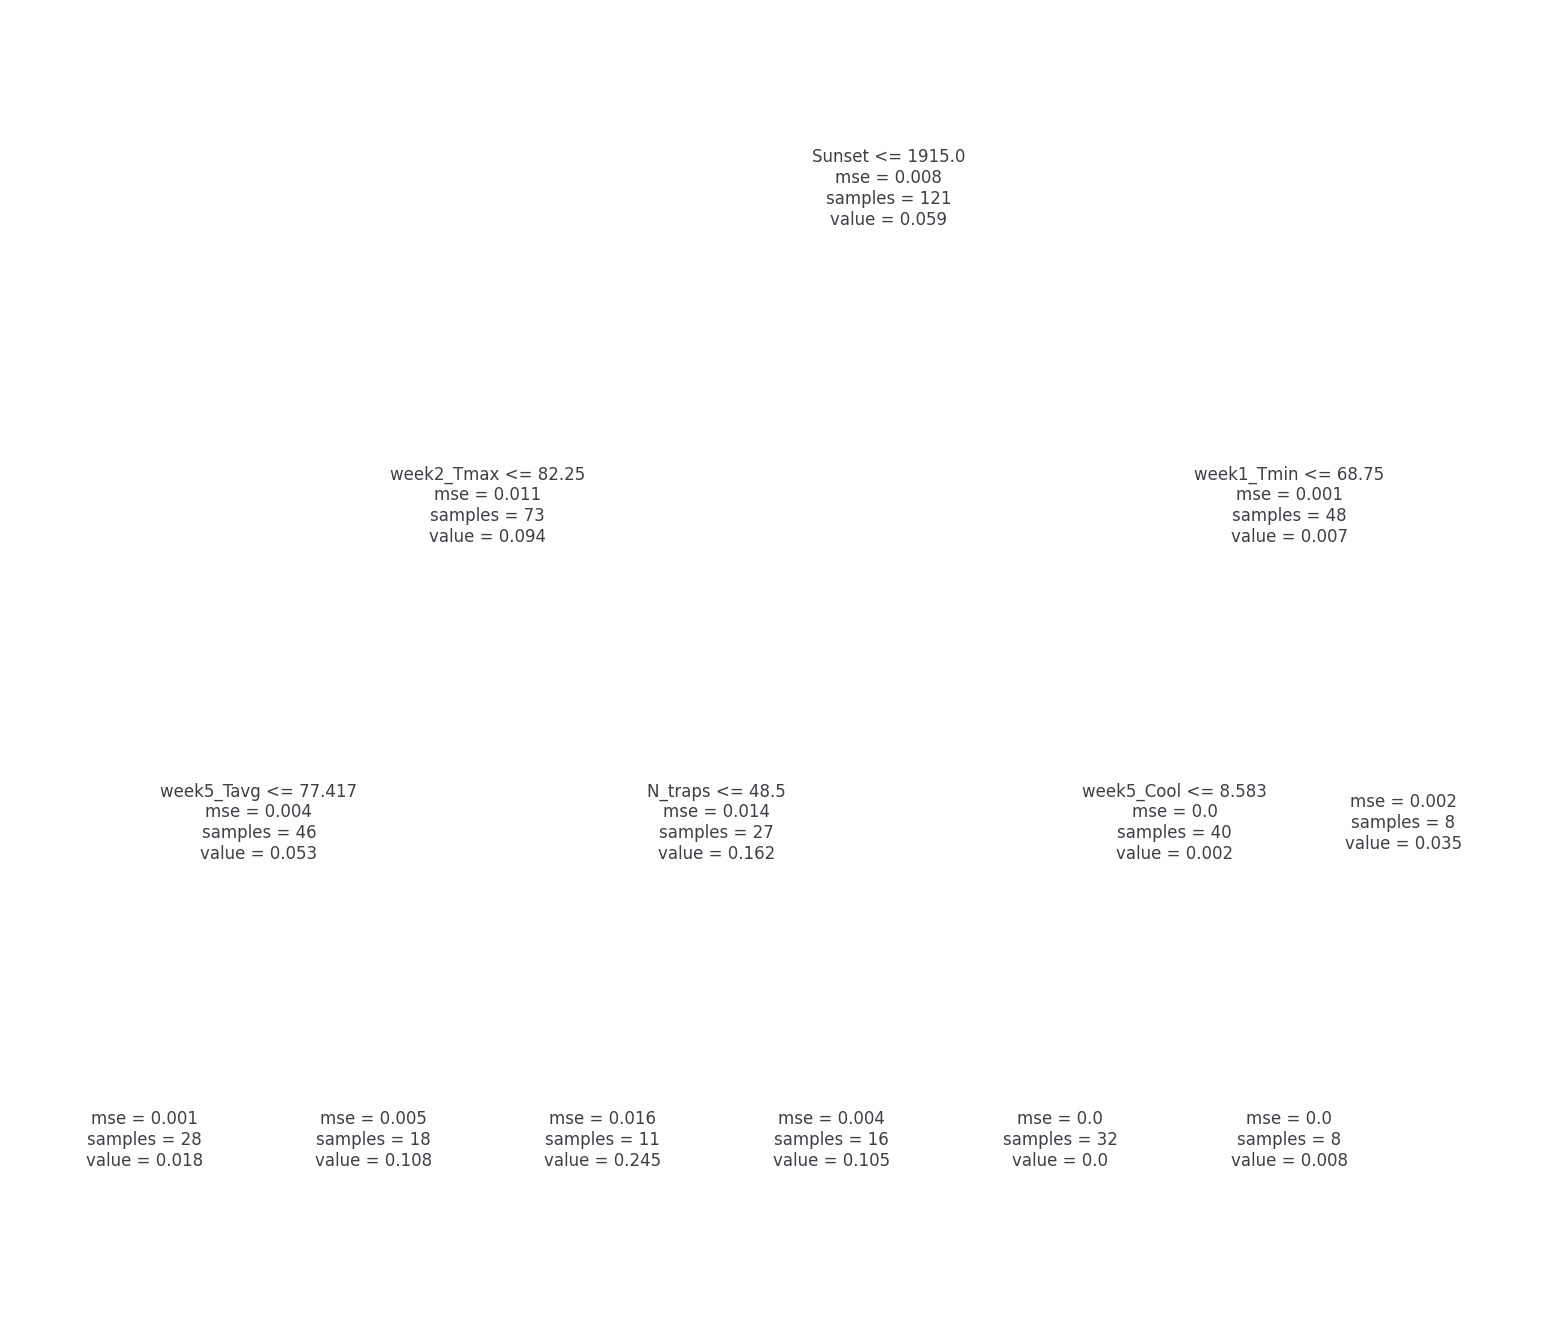

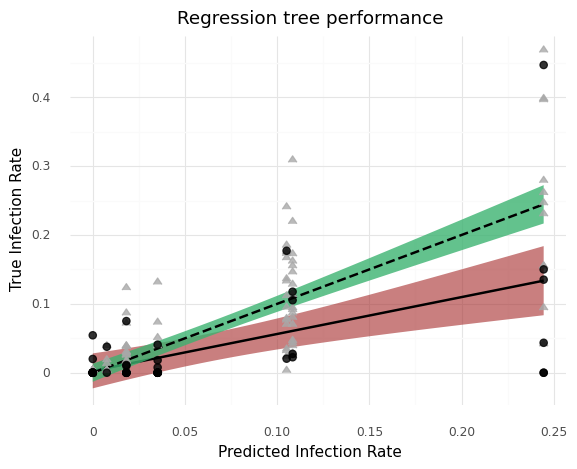

In [15]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# training, first 25 days of the month
train = training_set.loc[training_set.index.get_level_values('Date').day <= 24]
Y_train = train['Infection_rate']
X_train = train.drop(['Infection_rate'], axis=1)

# validation, last 5 days of the month
valid = training_set.loc[training_set.index.get_level_values('Date').day > 24]
Y_valid = valid['Infection_rate']
X_valid = valid.drop(['Infection_rate'], axis=1)

# train and plot regression tree
tree = DecisionTreeRegressor(max_depth=3, random_state=5, criterion='mse',
                            min_samples_leaf=8)
tree.fit(X_train, Y_train)
plot_tree(tree, feature_names=list(X_train.columns), rounded=True, fontsize=4)

# check validation 
preds = tree.predict(X_valid)
preds_train = tree.predict(X_train)
plot_df = pd.DataFrame({'Predicted Infection Rate': preds,
                        'True Infection Rate': Y_valid})
plot_df_train = pd.DataFrame({'Predicted Infection Rate': preds_train,
                        'True Infection Rate': Y_train})
valid_plot = (p9.ggplot(data=plot_df, mapping=p9.aes(x='Predicted Infection Rate', 
                                                     y='True Infection Rate'))
             + p9.theme_minimal()
   
             + p9.stat_smooth(method='lm', fill='brown', alpha=0.6)
             + p9.stat_smooth(data=plot_df_train, method='lm', fill='#3CB371',
                              linetype='dashed', alpha=0.8)
             + p9.geom_point(data=plot_df_train, color='darkgrey', 
                             shape=10, size=3, alpha=0.8)
             + p9.geom_point(size=2.5, alpha=0.8)
             + p9.ggtitle('Regression tree performance')
             + p9.labs(fill="Dataset")
             )
valid_plot.draw()
print(f"R2 values:\n", 
      f"training: {plot_df_train['Predicted Infection Rate'].corr(plot_df_train['True Infection Rate'])}",
      f"validation: {plot_df['Predicted Infection Rate'].corr(plot_df['True Infection Rate'])}")

### Insights
* Results seem good give the little amount of data provided (but they are very suceptible to random states).
* As expected, the regression tree overfits the training set.
* Need a way to break pseudoreplication issues without shrinking the training set too much.

## Feature Engineering II: interpolate Weather conditions  <a id='5'></a>
---

### Interpolate weather conditions and format for training

In [ ]:
# weather station LAT LON for stations 1 and 2
stations = [Point([-87.933, 41.995]), Point([-87.752, 41.786])]

                                    
# subset of interest for training
subset = ['Date', 'WnvPresent', 'NumMosquitos', 'Latitude', 'Longitude']

# get training subset 
traps_train = traps.drop([col for col in traps.columns if col not in subset], axis=1)

# interpolate weather conditions based on distance to weather station
trap_weather = pd.DataFrame()
for _, trap in traps_train.iterrows():
    
    # get distances from weather stations 1 and 2 and normalize to 1
    loc = Point([trap.Longitude, trap.Latitude])
    
    # set weather to station 2 if trap below station 2
    if trap.Latitude < 41.786:
        station_weights = [0, 1]
    else:
        station_weights = np.array([loc.distance(station) for station in stations])
        station_weights = station_weights / sum(station_weights)

    
    # get weather for date
    trap_weather = trap_weather.append(
        weather_train.loc[tuple([trap.Date, 1])] * station_weights[0] + 
        weather_train.loc[tuple([trap.Date, 2])] * station_weights[1], ignore_index=True)

# add weather to trap data
traps_train = pd.concat([traps_train, trap_weather], axis=1)
traps_train = traps_train.loc[-traps_train.week6_Tavg.isna()]

## Final Model  <a id='6'></a>
---

### Reformat data for training / validation

In [ ]:
# get train validation indices
train_idcs = [date.day <= 24 for date in traps_train.Date]
valid_idcs = [date.day > 24 for date in traps_train.Date]

# drop categorical columns / repeated columns and normalize input features
traps_train = traps_train.drop(['Date', 'Longitude', 'Latitude',
                               'Sunset', 'Sunrise'], axis=1)
traps_train = traps_train.astype(np.float32)

# min-max normalization
training_set = (traps_train - traps_train.min()) / (traps_train.max() - traps_train.min())

# training, first 25 days of the month
train = training_set.loc[train_idcs]
Y_train = train['WnvPresent'].values
X_train = train.drop(['WnvPresent'], axis=1)

# validation, last 5 days of the month
valid = training_set.loc[valid_idcs]
Y_valid = valid['WnvPresent'].values
X_valid = valid.drop(['WnvPresent'], axis=1)


### Fit random forest classifier and find best cutoff

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, plot_precision_recall_curve 
from sklearn.metrics import precision_recall_curve, plot_confusion_matrix, classification_report

# spawn random forest classifier
rf_classifier = RandomForestClassifier(max_depth=25, random_state=0, n_estimators=5000, 
                                       class_weight="balanced", max_samples=0.25, n_jobs=-1)

# train classifier and get predicted probabilities
rf_classifier.fit(X_train, Y_train)
Y_probs = rf_classifier.predict_proba(X_valid)[:, 1]

# plot auc curve and precision recall curve
auc = roc_auc_score(Y_valid, Y_probs)
precision, recall, _ = precision_recall_curve(Y_valid, Y_probs)
plot_roc_curve(rf_classifier, X_valid, Y_valid)
plot_precision_recall_curve(rf_classifier, X_valid, Y_valid)

In [ ]:
# find a cutoff for classification that gets a high recall without terrible precision
metrics = []
for cutoff in np.arange(0.01, 0.4, 0.005):
    precision = sum(Y_valid[Y_probs > cutoff]) / sum(Y_probs > cutoff)
    recall =sum(Y_probs[Y_valid == 1] > cutoff) / sum(Y_valid)
    f1 = 2 * (precision * recall / (precision + recall)) 
    if precision > 0.1 and recall > 0.6:
        metrics.append([recall + f1 * 1.5, cutoff, recall, f1, precision])

best = sorted(metrics, key=lambda x: -x[0])[0]
print(f'Best cutoff: {best[1]}',
     f'\n  recall at best cutoff: {best[2]}',
     f'\n  F1 at best cutoff: {best[3]}')

In [ ]:
# plot precision recall curve
plot_df = pd.DataFrame({'precision': [ele[-1] for ele in metrics],
                       'recall': [ele[2] for ele in metrics]})

prec_recall = (p9.ggplot(data=plot_df, mapping=p9.aes(x='precision', y='recall'))
              + p9.theme_minimal()
              + p9.geom_line(size=1.3)
              + p9.geom_point(x=best[4], y=best[2], size=10, 
                              alpha=0.4, color='red'))

prec_recall

### Find important features

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, rf_classifier.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances['feature'] = list(importances.index)
importances = importances.sort_values(by=['Gini-importance'])
plot_importance = plot_col(importances, 'feature', 'Gini-importance')

## Conclusions <a id='7'></a>
---
1. As expected, warm weather is a good predictor for WNV incidence. 
2. Predictions using Weather alone are not nearly as precise as those using mosquito trap data.
3. From the Gini-importance plot, there seems to be a small effect from weather conditions for the previous generation of *Culex* (Week5 variables)
 